In [1]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
# stats
import statsmodels.api as sm
from statsmodels import stats as sms
import statsmodels.formula.api as smf
from scipy import stats

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


# Parameters

In [2]:
DATA_DIR = '../data/10odorset_MOsubtracted_2secondsafteronset'
RNG_SEED = 1

# Model performance

## Utility functions

In [3]:
def logistic_regression_performance(data, rng=np.random.default_rng(0)):
    '''
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    '''
    # split data to X and y
    X = data.filter(like='feature').to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(
            f1_score(y[test_idx], model.predict(X[test_idx]), average=None)
        )
        accuracy.append(
            accuracy_score(y[test_idx], model.predict(X[test_idx]))
        )
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0]), 
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    return f1score_df, accuracy_df, true_labels, pred_labels

In [21]:
def logistic_regression_performance_dropout_removeall(data, num_features_to_remove=45, rng=np.random.default_rng(0)):
    '''
    This function is for removing  45 features at a time until all the features are removed, and test the model performance with the remaining features.
    
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        num_features_to_remove: int  # number of features to remove at each iteration
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
    
    Return:
        f1score_dfs: list of pd.DataFrame  # list of dataframes recording cross validated f1 scores
        accuracy_dfs: list of pd.DataFrame  # list of dataframes recording cross validated accuracy scores
    '''
    # Initial setup
    X_orig = data.filter(like='feature').to_numpy()
    y = data.odor.to_numpy()
    num_features = X_orig.shape[1]
    remaining_features = num_features

    # Data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    
    # Log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        num_features,
    )

    # Configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())

    # Results storage
    f1score_dfs = []
    accuracy_dfs = []

    # Loop to remove features
    while remaining_features >= num_features_to_remove:
        # Remove features
        feature_indices_to_remove = rng.choice(remaining_features, num_features_to_remove, replace=False)
        X = np.delete(X_orig, feature_indices_to_remove, axis=1)

        # Cross-validation setup
        cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))

        f1score = []
        accuracy = []
        true_labels = []  # List to store true labels
        pred_labels = []  # List to store predicted labels

        # Cross-validation loop
        for train_idx, test_idx in cv.split(X, y):
            # Train model on the training set
            model.fit(X[train_idx], y[train_idx])
            true_labels.extend(y[test_idx])
            # Obtain predicted labels
            pred_labels.extend(model.predict(X[test_idx]))
            # Evaluate on test set
            f1score.append(
                f1_score(y[test_idx], model.predict(X[test_idx]), average=None)
            )
            accuracy.append(
                accuracy_score(y[test_idx], model.predict(X[test_idx]))
            )

        # Aggregate results
        f1score = np.stack(f1score)
        accuracy = np.stack(accuracy)
        f1score_df = pd.DataFrame(
            data=f1score, 
            index=np.arange(f1score.shape[0]), 
            columns=model.classes_,
        )
        f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
        f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
        f1score_df['exp'] = data.exp.unique()[0]
        accuracy_df = pd.Series(accuracy).to_frame('accuracy')
        accuracy_df['exp'] = data.exp.unique()[0]

        # Store results
        f1score_dfs.append(f1score_df)
        accuracy_dfs.append(accuracy_df)

        # Update remaining features
        remaining_features -= num_features_to_remove

    return f1score_dfs, accuracy_dfs



In [12]:
cv_cycle = [item for item in range(5) for _ in range(2)]
cycles = []
for cycyle, (train_idx, test_idx) in zip(cv_cycle, cv.split(X, y)):
    ...
    cycles.append(cycle)

    
f1score_df['cycle'] = cycles
    

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

In [24]:
def logistic_regression_performance_dropout(data, rng=np.random.default_rng(0), remove_features=45):
    '''
   This function removes only 45 features( one neuron ) at a time sequentially, and test the model performance using the rest of the features( total features- 45 features)
   This one incldues the performance without removing any features
   
   Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
        remove_features: int  # Number of features to remove in each iteration
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    '''
    # split data to X and y
    X = data.filter(like='feature').to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    
    # Calculate F1 score when no features are removed
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(
            f1_score(y[test_idx], model.predict(X[test_idx]), average=None)
        )
        accuracy.append(
            accuracy_score(y[test_idx], model.predict(X[test_idx]))
        )
    
    for train_idx, test_idx in cv.split(X_subset, y):
            # train model on the training set
        model = model.fit(X_subset[train_idx], y[train_idx])
    
        start_idx = 0
    
        while start_idx < X.shape[1]:
             end_idx = min(start_idx + remove_features, X.shape[1])
             X_subset = np.delete(X, np.s_[start_idx:end_idx], axis=1)
        
        #for train_idx, test_idx in cv.split(X_subset, y):
            # train model on the training set
            #model = model.fit(X_subset[train_idx], y[train_idx])
             true_labels.extend(y[test_idx])
            # obtain predicted labels
             pred_labels.extend(model.predict(X_subset[test_idx]))
            # evaluate on test set
             f1score.append(
                f1_score(y[test_idx], model.predict(X_subset[test_idx]), average=None)
             )
            accuracy.append(
                accuracy_score(y[test_idx], model.predict(X_subset[test_idx]))
             )
        
         start_idx += remove_features
    
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0]),  # +1 for the initial calculation when no features are removed
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    return f1score_df, accuracy_df

# 1. use boolean maks instead of np.delete to improve readability
# 2. move the CV loop outside of the remove feature loop
# 3. optional: use for loop instead of while loop
# 4. add an indicator for: which neuron is removed, the repeat and CV cycle 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 77)

In [77]:
#Training and testing with different datasets
def logistic_regression_performance_cross(data_train, data_test, rng=np.random.default_rng(0)):
    '''
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    '''
    assert all(
        data_train.filter(like='feature').columns == data_test.filter(like='feature')
    ), 'columns of train and test do not align!'
    # split data to X and y
    X = data_train.filter(like='feature').to_numpy()
    y = data_train.odor.to_numpy()
    X_test = data_test.filter(like='feature').to_numpy()
    y_test = data_test.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert (data_train.exp.nunique() == 1) and (data_test.exp.nunique() == 1), "More than one experiment is found!"
    assert (data_train.isna().sum().sum() == 0) and (data_test.isna().sum().sum() == 0), "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        # evaluate on test set
        f1score.append(
            f1_score(y_test, model.predict(X_test), average=None)
        )
        accuracy.append(
            accuracy_score(y_test, model.predict(X_test))
        )
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0])
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    return f1score_df, accuracy_df,

In [5]:
def logistic_regression_performance_dropoutnew(data, rng=np.random.default_rng(0), remove_features=45):
    #this is the version with the removed features in the output
    '''
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
        remove_features: int  # Number of features to remove in each iteration
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
        split_indices: list  # list of split indices for each cross validation iteration
        last_removed_indices: list  # list of last removed feature indices for each round of feature removal
    '''
    # split data to X and y
    X = data.filter(like='feature').to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    split_indices = []  # List to store split indices
    last_removed_indices = []  # List to store last removed feature indices
    
    # Calculate F1 score when no features are removed
    for split_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(
            f1_score(y[test_idx], model.predict(X[test_idx]), average=None)
        )
        accuracy.append(
            accuracy_score(y[test_idx], model.predict(X[test_idx]))
        )
        split_indices.append(split_idx)
        last_removed_indices.append(0)  # 0 indicates no features removed
    
    start_idx = 0
    
    while start_idx < X.shape[1]:
        end_idx = min(start_idx + remove_features, X.shape[1])
        last_removed_index = end_idx - 1  # Index of the last removed feature
        X_subset = np.delete(X, np.s_[start_idx:end_idx], axis=1)
        
        for split_idx, (train_idx, test_idx) in enumerate(cv.split(X_subset, y)):
            # train model on the training set
            model = model.fit(X_subset[train_idx], y[train_idx])
            true_labels.extend(y[test_idx])
            # obtain predicted labels
            pred_labels.extend(model.predict(X_subset[test_idx]))
            # evaluate on test set
            f1score.append(
                f1_score(y[test_idx], model.predict(X_subset[test_idx]), average=None)
            )
            accuracy.append(
                accuracy_score(y[test_idx], model.predict(X_subset[test_idx]))
            )
            split_indices.append(split_idx)
            last_removed_indices.append(last_removed_index)
        
        start_idx += remove_features
    
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0]),  # +1 for the initial calculation when no features are removed
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    return f1score_df, accuracy_df, split_indices, last_removed_indices



In [70]:
def logistic_regression_performance_dropoutnewV1(data, rng=np.random.default_rng(0), remove_features=45):
    '''This is the version with the split index returned
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!
    
    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
        remove_features: int  # Number of features to remove in each iteration
    
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
        split_indices: list  # list of split indices for each cross validation iteration
    '''
    # split data to X and y
    X = data.filter(like='feature').to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        'There are %d trials where %d odors are presented %d times', 
        len(y),
        len(unique_odor),
        np.unique(counts)[0], 
    )
    logging.info(
        '%d features were extracted from population neural responses', 
        X.shape[1],
    )
    # configure model
    model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator))
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    split_indices = []  # List to store split indices
    
    # Calculate F1 score when no features are removed
    for split_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(
            f1_score(y[test_idx], model.predict(X[test_idx]), average=None)
        )
        accuracy.append(
            accuracy_score(y[test_idx], model.predict(X[test_idx]))
        )
        split_indices.append(split_idx)
    
    start_idx = 0
    
    while start_idx < X.shape[1]:
        end_idx = min(start_idx + remove_features, X.shape[1])
        X_subset = np.delete(X, np.s_[start_idx:end_idx], axis=1)
        
        for split_idx, (train_idx, test_idx) in enumerate(cv.split(X_subset, y)):
            # train model on the training set
            model = model.fit(X_subset[train_idx], y[train_idx])
            true_labels.extend(y[test_idx])
            # obtain predicted labels
            pred_labels.extend(model.predict(X_subset[test_idx]))
            # evaluate on test set
            f1score.append(
                f1_score(y[test_idx], model.predict(X_subset[test_idx]), average=None)
            )
            accuracy.append(
                accuracy_score(y[test_idx], model.predict(X_subset[test_idx]))
            )
            split_indices.append(split_idx)
        
        start_idx += remove_features
    
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score, 
        index=np.arange(f1score.shape[0]), # +1 for the initial calculation when no features are removed
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name='odor', value_name='f1_score')
    f1score_df['odor'] = pd.Categorical(f1score_df['odor'])
    f1score_df['exp'] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame('accuracy')
    accuracy_df['exp'] = data.exp.unique()[0]
    # Reset index of f1score_df and repeated_split_indices_df
    f1score_df.reset_index(drop=True, inplace=True)
    repeated_split_indices_df.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
   f1score_df = pd.concat([f1score_df, repeated_split_indices_df], axis=1)
    
    return f1score_df, accuracy_df, split_indices


In [5]:
def contributionofneurons_allneuron(_data):
    _data = _data.query('odor != 1')
    
    X = _data.filter(like='feature').to_numpy()
    y = _data.odor.to_numpy()
    
    # Train the logistic regression model
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X, y)
    
    # Get the coefficients (weights) of the logistic regression model
    coefficients = model.named_steps['logisticregression'].coef_
    
    # Reshape the coefficients matrix to represent each neuron with its weights across all time points
    num_neurons = coefficients.shape[1] // 45
    weights_by_neuron = coefficients.reshape(coefficients.shape[0], num_neurons, -1)
    
    return weights_by_neuron

In [6]:
# Initialize an empty list to store the weights for each experiment
weights_by_exp = []

# Iterate through each experiment
for exp in data.exp.unique():
    _data = data[data['exp'] == exp]
    _data = _data.dropna(axis=1)
    
    # Compute the weights for all neurons in the current experiment
    weights_by_neuron = contributionofneurons_allneuron(_data)
    
    # Append the weights for the current experiment to the list
    weights_by_exp.append(weights_by_neuron)

# Concatenate the weights of all experiments along the second axis (axis=1)
weightall = np.concatenate(weights_by_exp, axis=1)

# Verify the shape of the concatenated matrix
print("Shape of concatenated weight matrix:", weightall.shape)

NameError: name 'data' is not defined

In [168]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [102]:
import scipy.io



# Save the matrix to a MATLAB file
scipy.io.savemat('weightall.mat', {'weightall': weightall})

In [103]:
def contributionofneurons(_data):  # output 'weight sorted, weight before sorted'
 _data = _data.query('odor != 1')
 
 X = _data.filter(like='feature').to_numpy()
 y = _data.odor.to_numpy()
 model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
 model = model.fit(X, y)
    #plt.figure(figsize=[10,5])
    #sns.heatmap(model.named_steps['logisticregression'].coef_, cmap='bwr')

 datata=model.named_steps['logisticregression'].coef_

 chunk_size = 45

    # Calculate the averages for every 45 columns within the same row
 averages = [row[i:i+chunk_size].mean() for row in datata for i in range(0, len(row), chunk_size)]
 averages=abs(np.array(averages).reshape(datata.shape[0],int(datata.shape[1]/chunk_size)) )
 odorsorted=[]
 indices=[]
 for idx in range(len(averages)):
    _odorsorted=averages[idx, averages[idx, :].argsort()]
    _indices=averages[idx, :].argsort()
    odorsorted.append(_odorsorted)
    indices.append(_indices)
      #sns.heatmap(averages_odor2sorted, cmap='viridis')
 odor_sorted_ind=odorsorted+indices
 
 return odor_sorted_ind,averages

## Load data

In [4]:
# random seed used for all downstream analysis
rng = np.random.default_rng(RNG_SEED)
# load all data
data = []
for filename in pathlib.Path(DATA_DIR).glob('*.csv'):
    _data = pd.read_csv(filename, header=None)  # load csv file
    _data.columns = [f'feature_{i}' for i in range(len(_data.columns)-1)] + ['odor']  # rename columns
    _data['exp'] = filename.stem  # log experiment name as file name
    data.append(_data)
    logging.info(f'loaded dataset: {filename}')
data = pd.concat(data)
data


INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A88R1_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A62Nt_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A89Nt_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A60Nt_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A62-1_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A60R1_tracesfeature_odorbfcondition_2SECAFODORONSET.csv


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1400,feature_1401,feature_1402,feature_1403,feature_1404,feature_1405,feature_1406,feature_1407,feature_1408,feature_1409
0,-0.718362,0.199494,0.055107,0.301194,0.172896,-0.088771,0.373868,0.269899,0.303402,0.848818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.984994,0.388615,1.040464,0.740950,0.709422,-0.024784,1.126204,0.909083,1.275293,1.197262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.193753,-0.278944,0.210372,-0.092632,-0.324957,0.130552,-0.227694,0.219729,0.610293,0.670130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.868865,-0.193608,-0.207668,0.010147,0.063201,0.642120,0.521703,0.217043,1.154224,1.275466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.413068,0.661654,-0.174938,-0.656465,0.256498,-0.094289,-0.229805,-0.580694,0.236494,0.611319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.091044,0.013975,0.090620,-0.073001,-0.046873,-0.030406,0.019225,-0.087452,-0.201778,-0.094166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,1.061488,1.254464,0.941126,0.904491,0.585866,0.665367,0.428583,0.697744,0.691407,0.805563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,-0.493637,-0.163248,-0.190294,-0.034459,-0.028534,-0.428827,-0.184387,-0.294317,-0.113258,-0.344766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,-0.101009,-0.135995,-0.169606,-0.102096,-0.151483,-0.144072,-0.200476,-0.238199,-0.250655,-0.365136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# train data by experiment
f1score_df = []
accuracy_df = []
# Initialize lists to store true and predicted labels for all experiments
all_true_labels = []
all_pred_labels = []
for exp, _data in data.groupby('exp'):
    logging.info(f'Training models for {exp}:')
    _data = _data.dropna(axis=1)  # drop feature columns containing nans
    _data = _data.query("odor != 1")  # remove odor 1
    _data = _data.query("odor != 2")  # remove odor 2
    _data = _data.query("odor != 4")  # remove odor 10
    _data = _data.query("odor != 6")  # remove odor 10
    _data = _data.query("odor != 7")  # remove odor 10
    _data = _data.query("odor != 8")  # remove odor 11
    _data = _data.query("odor != 10")  # remove odor 10
    _data = _data.query("odor != 11")  # remove odor 11
    
    _f1score_df, _accuracy_df,_true_labels,_pred_labels= logistic_regression_performance(_data, rng=np.random.default_rng(0))
    
    f1score_df.append(_f1score_df)
    accuracy_df.append(_accuracy_df)
  
     # Append true labels and predicted labels to the lists for all experiments
    all_true_labels.extend(_true_labels)
    all_pred_labels.extend(_pred_labels)

accuracy_df = pd.concat(accuracy_df)
f1score_df = pd.concat(f1score_df)
# Compute the confusion matrix using all true and predicted labels
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)



INFO:root:Training models for A60Nt_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:630 features were extracted from population neural responses
INFO:root:Training models for A60R1_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:330 features were extracted from population neural responses
INFO:root:Training models for A62-1_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:960 features were extracted from population neural responses
INFO:root:Training models for A62Nt_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:There are 40 trials where 4 odors are presented 10 times
INFO:root:810 features were extracted from population neural responses
INFO:root:Training models for A88R1_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:There are 40 trials whe

In [6]:
# Initialize lists to store f1score and accuracy dataframes for each experiment
all_f1score_dfs = []
all_accuracy_dfs = []
allsplit_indices=[]
all_last_removed_indices=[]
# Initialize lists to store true and predicted labels for all experiments
all_true_labels = []
all_pred_labels = []

# Train data by experiment
for exp, _data in data.groupby('exp'):
    logging.info(f'Training models for {exp}:')
    _data = _data.dropna(axis=1)  # drop feature columns containing NaNs
    
    _f1score_dfs, _accuracy_dfs,_split_indices,_last_removed_indices = logistic_regression_performance_dropoutnew(_data, rng=np.random.default_rng(0), remove_features=45)
   # _split_indices
    all_f1score_dfs.append(_f1score_dfs)
    all_accuracy_dfs.append(_accuracy_dfs)
    allsplit_indices.append(pd.DataFrame({'split_index': _split_indices}))
    all_last_removed_indices.append(pd.DataFrame({'last_removed_indices': _last_removed_indices}))
    # Append true labels and predicted labels to the lists for all experiments
    #all_true_labels.extend(_true_labels)
    #all_pred_labels.extend(_pred_labels)

# Concatenate f1score and accuracy dataframes for all experiments
f1score_df = pd.concat(all_f1score_dfs)
accuracy_df = pd.concat(all_accuracy_dfs)
split_indices_df=pd.concat(allsplit_indices)
last_removed_indices_df=pd.concat(all_last_removed_indices)
repeated_split_indices_df = pd.concat([split_indices_df] * 4, ignore_index=True)
repeated_last_removed_indices_df = pd.concat([last_removed_indices_df] * 4, ignore_index=True)
# Reset index of f1score_df and repeated_split_indices_df
f1score_df.reset_index(drop=True, inplace=True)
repeated_split_indices_df.reset_index(drop=True, inplace=True)
repeated_last_removed_indices_df.reset_index(drop=True, inplace=True)
# Concatenate the DataFrames
merged_df = pd.concat([f1score_df, repeated_split_indices_df,repeated_last_removed_indices_df], axis=1)

INFO:root:Training models for A103R_tracesfeature_odorafcondition_2SECAFODORONSET:


NameError: name 'logistic_regression_performance_dropoutnew' is not defined

In [90]:
merged_df 



,odor,f1_score,exp,split_index,last_removed_indices
0,2,0.571429,040723_A66Nt_tracesfeature_odorafcondition_3SE...,0,0
1,2,0.615385,040723_A66Nt_tracesfeature_odorafcondition_3SE...,1,0
2,2,0.444444,040723_A66Nt_tracesfeature_odorafcondition_3SE...,2,0
3,2,0.888889,040723_A66Nt_tracesfeature_odorafcondition_3SE...,3,0
4,2,0.545455,040723_A66Nt_tracesfeature_odorafcondition_3SE...,4,0
...,...,...,...,...,...
4955,5,0.428571,102723_A94R1_tracesfeature_odorafcondition_3SE...,5,854
4956,5,0.444444,102723_A94R1_tracesfeature_odorafcondition_3SE...,6,854
4957,5,0.400000,102723_A94R1_tracesfeature_odorafcondition_3SE...,7,854
4958,5,0.181818,102723_A94R1_tracesfeature_odorafcondition_3SE...,8,854


In [109]:
f1score_df.groupby(['exp', 'odor'])['f1_score'].size()

exp                                                            odor
033023_A66Nt_tracesfeature_odorbfcondition_3SECAFODORONSET     2       10
                                                               3       10
                                                               4       10
                                                               5       10
060223_A75L1_tracesfeature_odorbfcondition_3SECAFODORONSET     2       10
                                                               3       10
                                                               4       10
                                                               5       10
072624_A134R1_tracesfeature_odorbfcondition_3SECAFODORONSET    2       10
                                                               3       10
                                                               4       10
                                                               5       10
072624_A137Nt_tracesfeature_odorbfcondition_

In [110]:
# Group by every 10 rows and compute the mean of the "f1_score" column
averaged_f1_scores = merged_df.groupby(np.arange(len(merged_df )) // 10)['f1_score'].mean()

# Create a DataFrame with the averaged values, odor, and exp columns
averaged_df = pd.DataFrame({
    'average_f1_score': averaged_f1_scores.values,
    'odor': merged_df.groupby(np.arange(len(merged_df)) // 10)['odor'].first().values,
    'exp': merged_df.groupby(np.arange(len(merged_df)) // 10)['exp'].first().values,
    'split_index': merged_df.groupby(np.arange(len(merged_df)) // 10)['split_index'].first().values,
    'last_removed_indices': merged_df.groupby(np.arange(len(merged_df)) // 10)['last_removed_indices'].first().values
})

# Display the resulting DataFrame
print(averaged_df)

NameError: name 'merged_df' is not defined

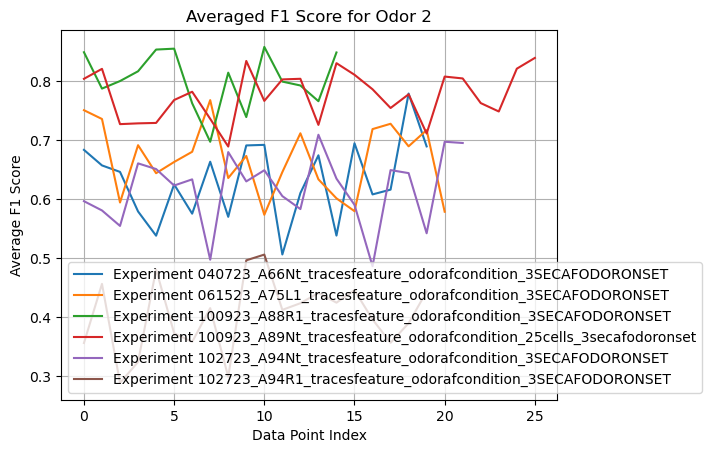

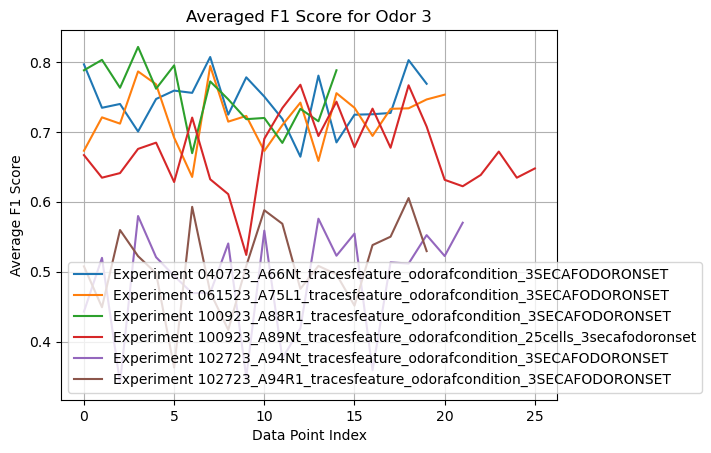

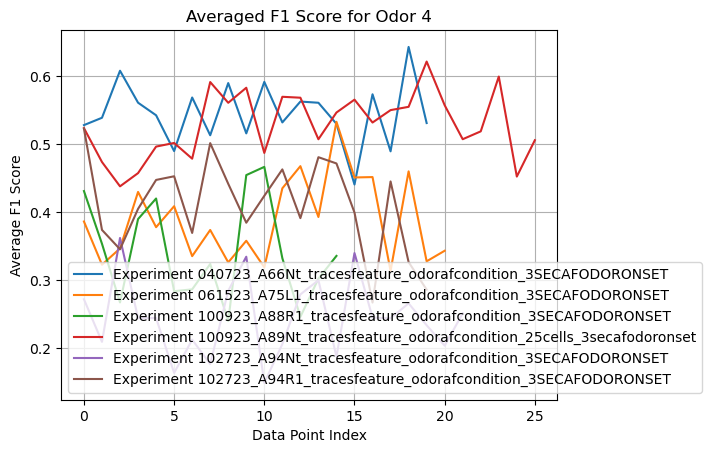

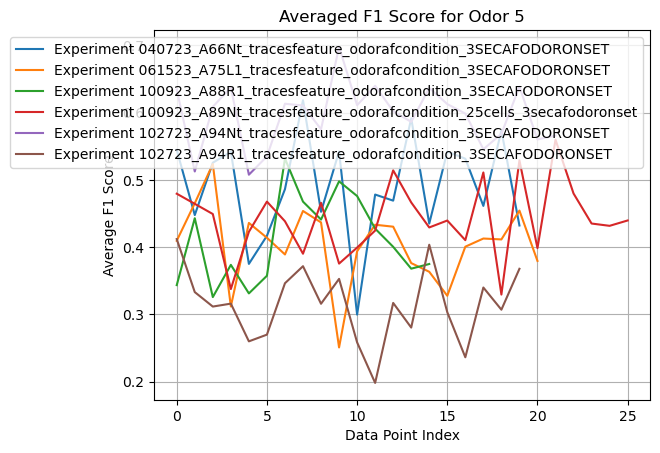

In [96]:
grouped_by_odor = averaged_df.groupby('odor')

# Iterate over each odor
for odor, group_df in grouped_by_odor:
    # Create a new figure for each odor
    plt.figure()
    
    # Plot title
    plt.title(f'Averaged F1 Score for Odor {odor}')
    
    # Get the maximum number of data points across all experiments for this odor
    max_num_data_points = group_df.groupby('exp').size().max()
    
    # Define x-values starting from 0 to max_num_data_points - 1
    x_values = np.arange(max_num_data_points)
    
    # Group by experiment within each odor
    grouped_by_exp = group_df.groupby('exp')
    
    # Plot each experiment with a different color
    for exp, exp_df in grouped_by_exp:
        # Determine y-values for this experiment
        y_values = np.full(max_num_data_points, np.nan)
        y_values[:len(exp_df)] = exp_df['average_f1_score']
        
        # Plot the data
        plt.plot(x_values, y_values, label=f'Experiment {exp}')
    
    plt.xlabel('Data Point Index')
    plt.ylabel('Average F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
#get the difference of F1 score after removing the neurons

grouped_df = averaged_df.groupby(['odor', 'exp'])

# Define a function to subtract F1 scores
def subtract_first_subject_score(group):
    first_subject_score = group['average_f1_score'].iloc[0]  # Get F1 score of the first subject in the group
    group['Adjusted_F1score'] = -group['average_f1_score'] + first_subject_score  # Subtract F1 score of the first subject from all subjects
    return group

# Apply the function to each group
adjusted_df = grouped_df.apply(subtract_first_subject_score)
# Merge adjusted_df with the original DataFrame based on index
averaged_df = pd.merge(averaged_df, adjusted_df[['Adjusted_F1score']], left_index=True, right_index=True)
# Print the adjusted DataFrame
print(averaged_df)


NameError: name 'averaged_df' is not defined

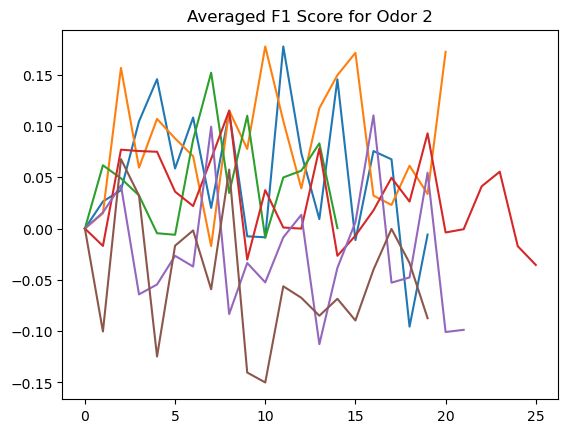

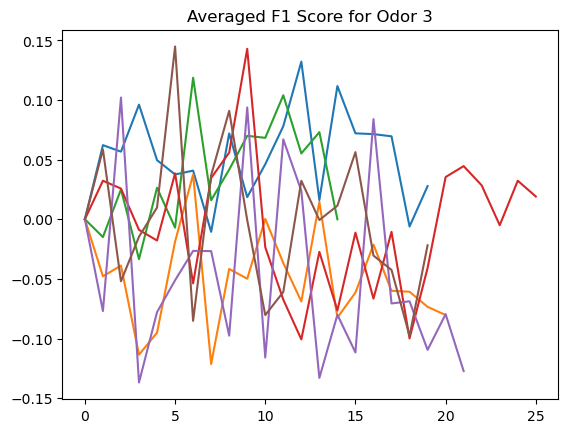

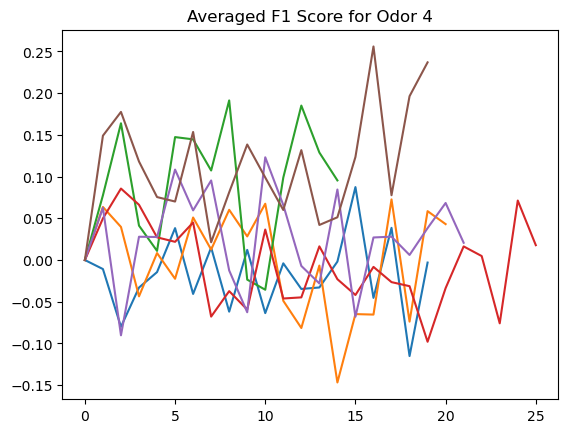

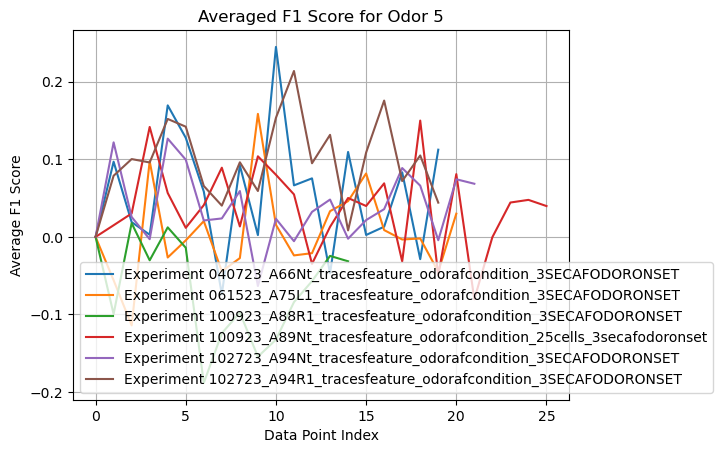

In [110]:
# Initialize variables to store y_values for each odor
y_values_odor2 = []
y_values_odor3 = []
grouped_by_odor = averaged_df.groupby('odor')

# Iterate over each odor
for odor, group_df in grouped_by_odor:
    # Create a new figure for each odor
    plt.figure()
    
    # Plot title
    plt.title(f'Averaged F1 Score for Odor {odor}')
    
    # Get the maximum number of data points across all experiments for this odor
    max_num_data_points = group_df.groupby('exp').size().max()
    
    # Define x-values starting from 0 to max_num_data_points - 1
    x_values = np.arange(max_num_data_points)
    
    # Group by experiment within each odor
    grouped_by_exp = group_df.groupby('exp')
    
    # Plot each experiment with a different color
    for exp, exp_df in grouped_by_exp:
        # Determine y-values for this experiment
        y_values = np.full(max_num_data_points, np.nan)
        y_values[:len(exp_df)] = exp_df['Adjusted_F1score']
        
        # Store y_values for odor 2 and odor 3
        if odor == 2:
            y_values_odor2.append(y_values)
        elif odor == 3:
            y_values_odor3.append(y_values)
        
        # Plot the data
        plt.plot(x_values, y_values, label=f'Experiment {exp}')
plt.xlabel('Data Point Index')
plt.ylabel('Average F1 Score')
plt.legend()
plt.grid(True)
plt.show()
# Concatenate y_values for each odor across all experiments
y_values_odor2 = np.concatenate(y_values_odor2)
y_values_odor3 = np.concatenate(y_values_odor3)

# Rename y_values
odor2 = y_values_odor2
odor3 = y_values_odor3


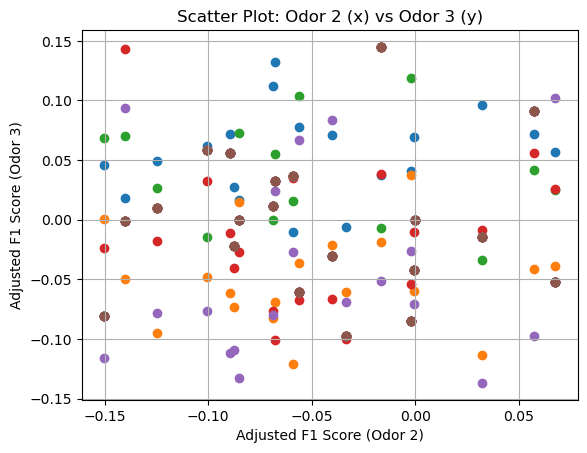

In [117]:
# Initialize variables to store x and y values for each odor
x_values_odor2 = []
y_values_odor3 = []
colors = {}  # Dictionary to store colors for each experiment

# Group by odor
grouped_by_odor = averaged_df.groupby('odor')

# Iterate over each odor
for odor, group_df in grouped_by_odor:
    # Get the maximum number of data points across all experiments for this odor
    max_num_data_points = group_df.groupby('exp').size().max()
    
    # Group by experiment within each odor
    grouped_by_exp = group_df.groupby('exp')
    
    # Plot each experiment with a different color
    for exp, exp_df in grouped_by_exp:
        # Determine x-values for Odor 2
        if odor == 2:
            x_values = np.full(max_num_data_points, np.nan)
            x_values[:len(exp_df)] = exp_df['Adjusted_F1score']
            x_values_odor2.append(x_values)
        # Determine y-values for Odor 3
        elif odor == 3:
            y_values = np.full(max_num_data_points, np.nan)
            y_values[:len(exp_df)] = exp_df['Adjusted_F1score']
            y_values_odor3.append(y_values)
        
        # Scatter plot
        if y_values_odor3:  # Check if y_values_odor3 is not empty
            color = colors.get(exp)
            if color is None:
                color = plt.cm.tab10(len(colors) % 10)  # Get a color from the default color cycle
                colors[exp] = color
            plt.scatter(x_values_odor2[-1], y_values_odor3[-1], label=f'Experiment {exp}', color=color)

# Set plot labels and legend
plt.title('Scatter Plot: Odor 2 (x) vs Odor 3 (y)')
plt.xlabel('Adjusted F1 Score (Odor 2)')
plt.ylabel('Adjusted F1 Score (Odor 3)')
#plt.legend()
plt.grid(True)
plt.show()


In [107]:
grouped_by_odor

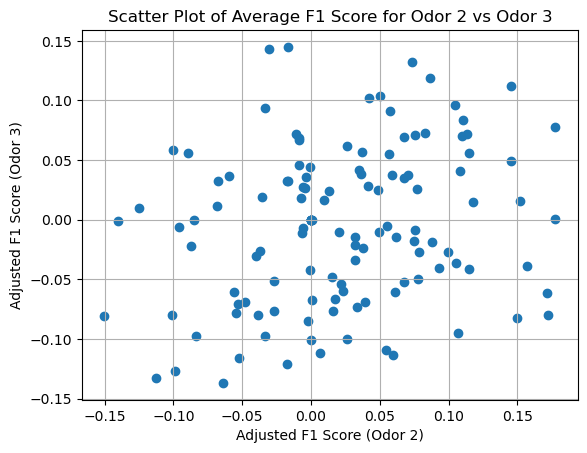

In [115]:
plt.figure()
plt.scatter(x_values_odor2, y_values_odor3)
plt.xlabel('Adjusted F1 Score (Odor 2)')
plt.ylabel('Adjusted F1 Score (Odor 3)')
plt.title('Scatter Plot of Average F1 Score for Odor 2 vs Odor 3')
plt.grid(True)
plt.show()



In [82]:
averaged_df.to_csv('averaged_f1_scores_45featuresatatime.csv', index=False)

In [87]:
averaged_df_odor=averaged_df.groupby('odor')
print(averaged_df_odor)

In [25]:

# Calculate average F1 score for every 10 dataframes for each experiment
f1score_dfs_avg = []
for exp in f1score_df:
    f1score_dfs_exp_avg = []
    for i in range(1, len(exp), 10):
        avg_df = pd.concat(exp[i:i+10]).groupby('odor')['f1_score'].mean().reset_index()
        f1score_dfs_exp_avg.append(avg_df)
    f1score_dfs_avg.append(f1score_dfs_exp_avg)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "str"

Confusion Matrix for all animals:
[[137  49  38  76]
 [ 58 141  66  35]
 [ 63  64 117  56]
 [ 84  41  49 126]]


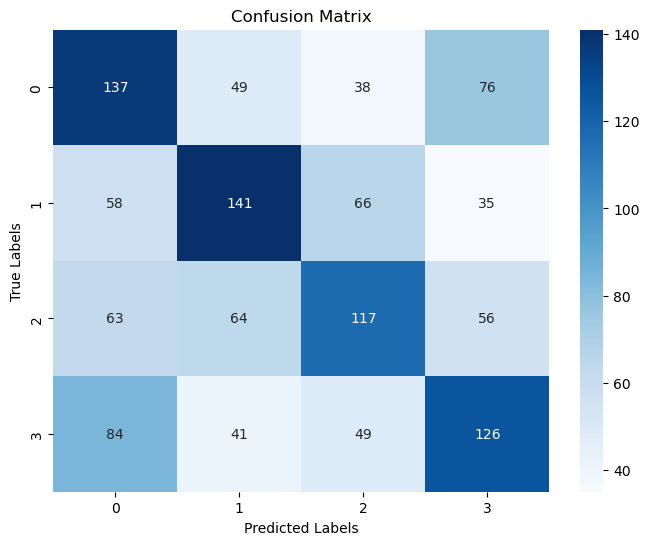

In [14]:
print("Confusion Matrix for all animals:")
print(conf_matrix)
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix for all animals:
[[170 127 103 100]
 [ 98 115 163 124]
 [ 50 135 183 132]
 [ 82 107 157 154]]


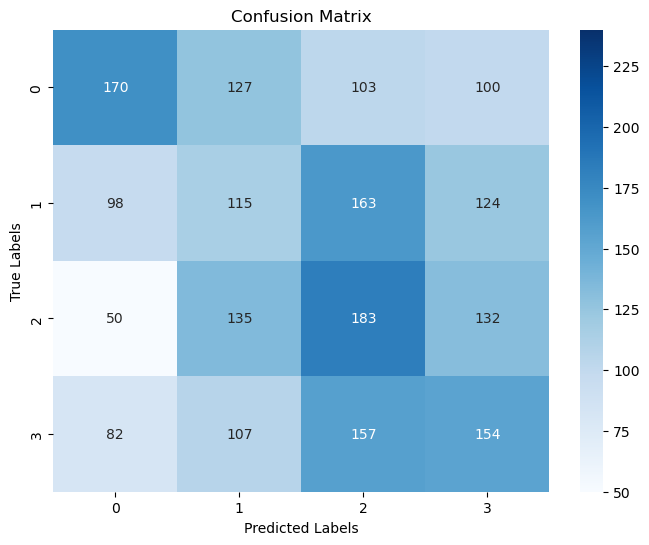

In [111]:
print("Confusion Matrix for all animals:")
print(conf_matrix)
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",vmin=50, vmax=240)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Draft

In [58]:
exps=data.exp.unique()
weightall_sorted=[]
weightall=np.empty((4,0))
for exp in exps:

    _data=data[data['exp']==exp]
    _data=_data.dropna(axis=1)
    
    weight_sorted= contributionofneurons_allneuron(_data)[0]
    weight=np.array(contributionofneurons_allneuron(_data)[1])
    weightall_sorted=weightall_sorted+weight_sorted+[exp]
    
    weightall=np.hstack((weightall,weight))
#weightall_sorted=pd.DataFrame(weightall)

#weightall.to_csv("weightall.csv", index=False)



ValueError: operands could not be broadcast together with shapes (0,) (21,45) 

In [9]:
weight23=np.empty((78,2))
weight23[:,0]=weightall[0]
weight23[:,1]=weightall[1]


ValueError: could not broadcast input array from shape (50,) into shape (78,)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

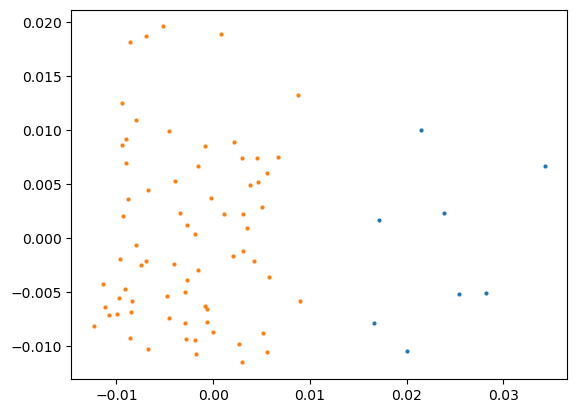

In [675]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca=PCA(n_components=2)
principal_components=pca.fit_transform(weight23)
kmeans=KMeans(n_clusters=2)
cluster_labels=kmeans.fit_predict(weight23)
labels=np.unique(cluster_labels)
for i in labels:
    plt.scatter(principal_components[cluster_labels==i,0],principal_components[cluster_labels==i,1],label=i,s=4)
cluster_labels

[47 15 51 17  5 50 66 41 42  0 76 71  9  7 59  1 22 32 38 11 18 75  3 12
 10 24 72 70 74 62 63 49 20 45 73 26 57 39 34 43  6 77 16 54 52 64 68 65
  8 37 48 28 56 40 21 55 33 46 60 23 53 35  2  4 36 27 13 19 29 14 25 31
 69 44 58 30 61 67]


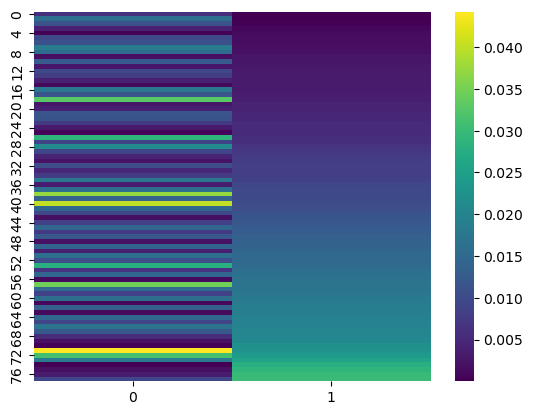

In [682]:

indices=np.argsort(weight23[:,1])
weight23_sorted=weight23[indices]
sns.heatmap(weight23_sorted, cmap='viridis')
print(indices)



In [37]:
datata=model.named_steps['logisticregression'].coef_

chunk_size = 45

# Calculate the averages for every 45 columns within the same row
averages = [row[i:i+chunk_size].mean() for row in datata for i in range(0, len(row), chunk_size)]
np.array(averages).shape
averages=abs(np.array(averages).reshape(datata.shape[0],int(datata.shape[1]/chunk_size)) )
averages_odor2sorted=averages[:, averages[0, :].argsort()]
indices=averages[0, :].argsort()
sns.heatmap(averages_odor2sorted, cmap='viridis')
indices

NameError: name 'model' is not defined

In [528]:
_data = data.query('exp=="033023_A66Nt_tracesfeature_odorbfcondition_3SECAFODORONSET"')
X = _data.filter(like='feature').to_numpy()
y = _data.odor.to_numpy()
model = make_pipeline(StandardScaler(), LogisticRegression())  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
model = model.fit(X, y)
plt.figure(figsize=[20,10])
sns.heatmap(model.named_steps['logisticregression'].coef_, cmap='bwr')

/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: >

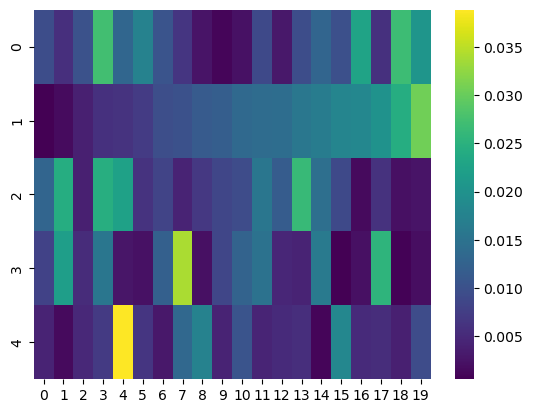

In [27]:
datata=model.named_steps['logisticregression'].coef_
chunk_size = 45

# Calculate the averages for every 45 columns within the same row
averages = [row[i:i+chunk_size].mean() for row in datata for i in range(0, len(row), chunk_size)]

averages=abs(np.array(averages).reshape(5,20))
averages_odor2sorted=averages[:, averages[1, :].argsort()]
sns.heatmap(averages_odor2sorted, cmap='viridis')

## Model training

## Model training, cross condition testing

In [42]:
# train data by experiment
_f1score_df, _accuracy_df = logistic_regression_performance_cross(
    data_train = data.query("exp==exp[0]"),
    # data_test = data.query("exp=='033023_A66Nt_tracesfeature_odorbfcondition_3SECAFODORONSET'"),
    data_test = data.query("exp==exp[0]"),
    rng=rng,
)

NameError: name 'logistic_regression_performance_cross' is not defined

## Visualization - merge animal
The following visualization first computes cross-validated model prediction score by animal and visualizes mean model prediction score and SEM aross animal (n=number of animal).

**NOTE: the code currently assumes one file contains one animal**

In [9]:
num_odor = data.groupby('exp').odor.apply(lambda x : len(np.unique(x))).unique()
assert len(num_odor) == 1, "Experiments have different number of odors presented!"
num_odor = int(num_odor)
chance_f1 = 1 / num_odor  # assuming random guess and balanced experimental design
chance_accuracy = 1 / num_odor
num_odor



12

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

NameError: name 'chance_f1' is not defined

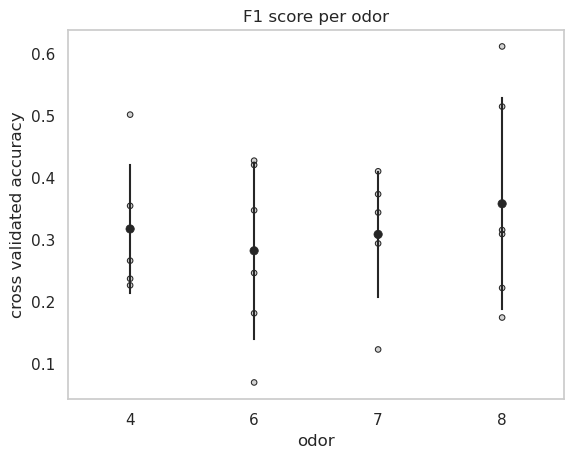

In [8]:
f1score_df_animal_mean = (
    f1score_df
    .groupby(['odor', 'exp'])
    .agg('mean')
    .reset_index()
)

fig = plt.figure()
(
    f1score_df_animal_mean
    .pipe(so.Plot, x='odor', y='f1_score')
    .add(so.Dots(color='k'), so.Dodge())
    .add(so.Dot(color='k'), so.Agg(), so.Dodge())
    .add(so.Range(color='k'), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated accuracy', x='odor', title='F1 score per odor')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)
plt.axhline(chance_f1, label='chance level', color='k', linestyle='--')
plt.ylim(0, 1)


In [15]:
f1score_df_animal_mean.to_csv('10odorset_4odormodel_f1score_2secafonset_aversive.csv')

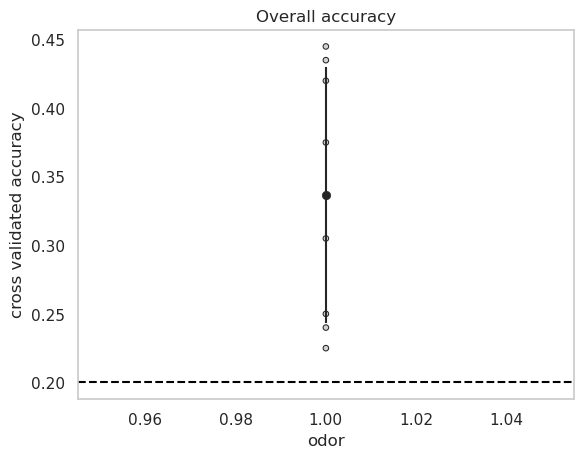

In [140]:
accuracy_df_animal_mean = (
    accuracy_df
    .groupby('exp')
    .agg('mean')
    .reset_index()
)
accuracy_df_animal_mean['x'] = 1  # place holder for plotting

fig = plt.figure()
(
    accuracy_df_animal_mean
    .pipe(so.Plot, x='x', y='accuracy')
    .add(so.Dots(color='k'), so.Dodge())
    .add(so.Dot(color='k'), so.Agg(), so.Dodge())
    .add(so.Range(color='k'), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated accuracy', x='odor', title='Overall accuracy')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)
plt.axhline(chance_accuracy, label='chance level', color='k', linestyle='--')


## Stats across animals
**NOTE: These data points are i.i.d samples. These results are more trustworthy than the following per animal tests.**

### Whether overall accuracy is significant?

In [99]:
stats.ttest_1samp(accuracy_df_animal_mean.accuracy, chance_accuracy)  # test whether model could predict odors better than chance

TtestResult(statistic=16.358740118120235, pvalue=5.300783169067996e-08, df=9)

### Whether per class f1 score is significant? 

In [100]:
pvalues = []
for odor, trials in f1score_df.groupby('odor'):
    t, p = stats.ttest_1samp(trials.f1_score, chance_f1)
    pvalues.append(dict(odor=odor, p=p))  # store p values for visualization later
pvalues = pd.DataFrame(pvalues)
pvalues['p'] = sms.multitest.fdrcorrection(pvalues['p'])[1]  # correct pvalues for multiple comparisons across odors
display(pvalues)

,odor,p
0,2,2.671723e-44
1,3,1.411006e-43
2,4,4.517393e-32
3,5,3.999523e-30


### Whether there are differences in performance across odor?

In [115]:
# 1-way anova
print(sm.stats.anova_lm(smf.ols(data=f1score_df_animal_mean, formula='f1_score ~ C(odor)').fit()))
# pair-wise comparison
pvalues = []
for odor1, odor2 in combinations(f1score_df_animal_mean.odor.unique(), 2):
    t, p = stats.ttest_ind(f1score_df_animal_mean.loc[f1score_df_animal_mean.odor==odor1, 'f1_score'], f1score_df_animal_mean.loc[f1score_df_animal_mean.odor==odor2, 'f1_score'])
    if t > 0:
        pvalues.append({'test':f'{odor1} > {odor2}', 'p':p})
    else:
        pvalues.append({'test':f'{odor1} < {odor2}', 'p':p})
pvalues = pd.DataFrame(pvalues)
pvalues['sig'] = sms.multitest.fdrcorrection(pvalues.p)[0]
pvalues.p = sms.multitest.fdrcorrection(pvalues.p)[1]
print(pvalues)

            df    sum_sq   mean_sq         F    PR(>F)
C(odor)    3.0  0.079781  0.026594  1.214062  0.318597
Residual  36.0  0.788571  0.021905       NaN       NaN
    test         p    sig
0  2 > 3  0.438646  False
1  2 > 4  0.691137  False
2  2 > 5  0.610887  False
3  3 < 4  0.181520  False
4  3 < 5  0.570019  False
5  4 > 5  0.610887  False


## <font color='red'>NOTE: The following tests are based on cross-validated model performance scores. These scores are not i.i.d samples and tests based on them are known to have an inflated type I error. Avoid using them if possible.

## Visualization per animal

In [129]:
num_odor = data.groupby('exp').odor.apply(lambda x : len(np.unique(x))).unique()
assert len(num_odor) == 1, "Experiments have different number of odors presented!"
num_odor = int(num_odor)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

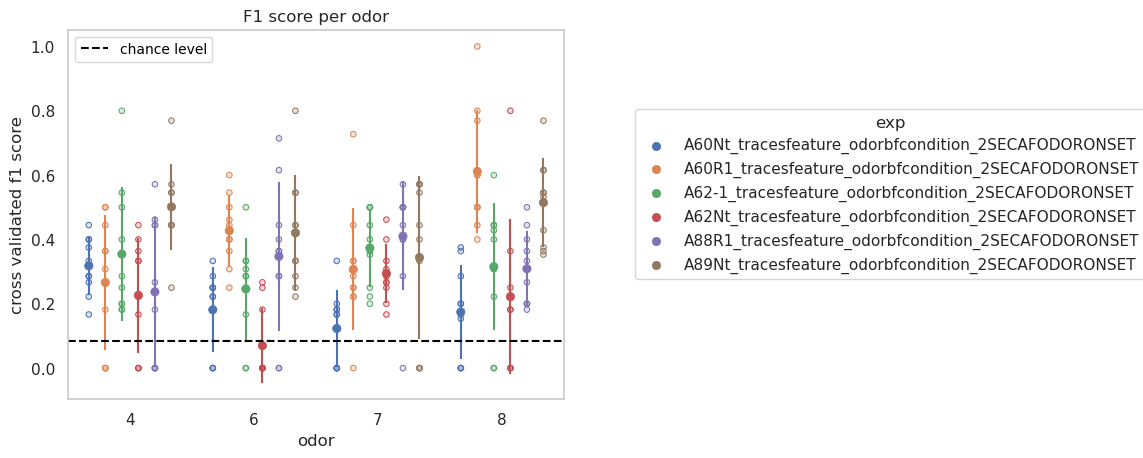

In [10]:
fig = plt.figure()
(
    f1score_df
    .pipe(so.Plot, x='odor', y='f1_score', color='exp')
    .add(so.Dots(), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated f1 score', title='F1 score per odor')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)

chance_f1 = 1 / num_odor  # assuming random guess and balanced experimental desing
plt.axhline(chance_f1, label='chance level', color='k', linestyle='--')
plt.legend()




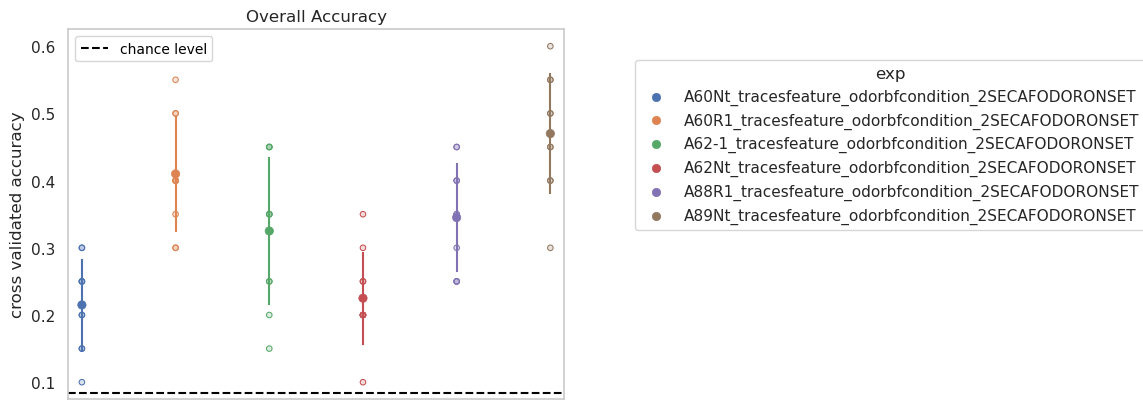

In [11]:
fig = plt.figure()
(
    accuracy_df
    .pipe(so.Plot, x='exp', y='accuracy', color='exp')
    .add(so.Dots(), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .label(y='cross validated accuracy', x='', title='Overall Accuracy')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ""})
    .on(fig)
    .plot()
)
plt.xticks([], [])
chance_accuracy = 1 / num_odor
plt.axhline(chance_accuracy, label='chance level', color='k', linestyle='--')  #TODO: baseline = 1/num of odors, it is hard-coded to be 5 here, ideally this value should come from data
plt.legend()

In [119]:
from scipy import stats
from statsmodels import stats as sms
from statsmodels import api as sm
from statsmodels.formula import api as smf

### Whether overall accuracy is significant?

In [120]:
accuracy_df['p'] = np.nan
for exp, trials in accuracy_df.groupby('exp'):
    t, p = stats.ttest_1samp(trials.accuracy, chance_accuracy)
    accuracy_df.loc[accuracy_df.exp==exp, 'p'] = p  # store p values for visualization later

accuracy_df[['exp', 'p']].drop_duplicates()

,exp,p
0,033023_A66Nt_tracesfeature_odorbfcondition_3SE...,0.397385
0,060223_A75L1_tracesfeature_odorbfcondition_3SE...,0.103888
0,072624_A134R1_tracesfeature_odorbfcondition_3S...,0.009535
0,072624_A137Nt_tracesfeature_odorbfcondition_2S...,0.127846
0,072624_A137Nt_tracesfeature_odorbfcondition_3S...,0.127846
0,100223_A88R1_tracesfeature_odorbfcondition_3SE...,0.000118
0,100223_A89Nt_tracesfeature_odorbfcondition_3se...,0.000004
0,102023_A94Nt_tracesfeature_odorbfcondition_3SE...,0.000009
0,102023_A94R1_tracesfeature_odorbfcondition_3SE...,0.001829
0,A103R1_tracesfeature_odorbfcondition_3SECAFODO...,0.000020


### Whether per class f1 score is significant? 

In [121]:
pvalues = []
for exp, odors in f1score_df.groupby('exp'):
    for odor, trials in odors.groupby('odor'):
        t, p = stats.ttest_1samp(trials.f1_score, chance_f1)
        pvalues.append(dict(exp=exp, odor=odor, p=p))  # store p values for visualization later
pvalues = pd.DataFrame(pvalues)
pvalues['p'] = pvalues.groupby('exp')['p'].transform(lambda p : sms.multitest.fdrcorrection(p.to_numpy())[1])  # correct pvalues for multiple comparisons across odors
f1score_df = f1score_df.merge(pvalues)

f1score_df[['exp', 'odor', 'p']].drop_duplicates()

,exp,odor,p
0,033023_A66Nt_tracesfeature_odorbfcondition_3SE...,2,0.835322
10,033023_A66Nt_tracesfeature_odorbfcondition_3SE...,3,0.835322
20,033023_A66Nt_tracesfeature_odorbfcondition_3SE...,4,0.340084
30,033023_A66Nt_tracesfeature_odorbfcondition_3SE...,5,0.340084
40,060223_A75L1_tracesfeature_odorbfcondition_3SE...,2,0.780305
50,060223_A75L1_tracesfeature_odorbfcondition_3SE...,3,0.725502
60,060223_A75L1_tracesfeature_odorbfcondition_3SE...,4,0.865044
70,060223_A75L1_tracesfeature_odorbfcondition_3SE...,5,0.145006
80,072624_A134R1_tracesfeature_odorbfcondition_3S...,2,0.707497
90,072624_A134R1_tracesfeature_odorbfcondition_3S...,3,0.210008


### Whether there are differences in performance across odor?

In [122]:
for exp, odors in f1score_df.groupby('exp'):
    # 1-way anova
    print(exp)
    print(sm.stats.anova_lm(smf.ols(data=odors, formula='f1_score ~ C(odor)').fit()))
    # pair-wise comparison
    pvalues = []
    for odor1, odor2 in combinations(odors.odor.unique(), 2):
        t, p = stats.ttest_ind(odors.loc[odors.odor==odor1, 'f1_score'], odors.loc[odors.odor==odor2, 'f1_score'])
        if t > 0:
            pvalues.append({'test':f'{odor1} > {odor2}', 'p':p})
        else:
            pvalues.append({'test':f'{odor1} < {odor2}', 'p':p})
    pvalues = pd.DataFrame(pvalues)
    pvalues['sig'] = sms.multitest.fdrcorrection(pvalues.p)[0]
    pvalues.p = sms.multitest.fdrcorrection(pvalues.p)[1]
    print(pvalues)

033023_A66Nt_tracesfeature_odorbfcondition_3SECAFODORONSET
            df    sum_sq   mean_sq         F    PR(>F)
C(odor)    3.0  0.168644  0.056215  2.141113  0.112073
Residual  36.0  0.945173  0.026255       NaN       NaN
    test         p    sig
0  2 > 3  0.727850  False
1  2 < 4  0.348986  False
2  2 > 5  0.348986  False
3  3 < 4  0.348986  False
4  3 > 5  0.348986  False
5  4 > 5  0.219866  False
060223_A75L1_tracesfeature_odorbfcondition_3SECAFODORONSET
            df    sum_sq   mean_sq         F    PR(>F)
C(odor)    3.0  0.181927  0.060642  3.427906  0.027147
Residual  36.0  0.636869  0.017691       NaN       NaN
    test         p    sig
0  2 < 3  0.952258  False
1  2 < 4  0.715964  False
2  2 < 5  0.100219  False
3  3 < 4  0.715964  False
4  3 < 5  0.100083  False
5  4 < 5  0.135988  False
072624_A134R1_tracesfeature_odorbfcondition_3SECAFODORONSET
            df    sum_sq   mean_sq         F    PR(>F)
C(odor)    3.0  0.097209  0.032403  2.422811  0.081737
Residual  36.0  0.